In [1]:
%matplotlib inline
import cv2
from matplotlib import pyplot as plt
import numpy as np
import glob

In [2]:
image = cv2.imread("media/test_images/straight_lines1.jpg")

## Visualization part

In [3]:
def show_image(image, title='Image', cmap_type='gray'):
    plt.imshow(image, cmap = cmap_type)
    plt.title(title)

## Read an Image

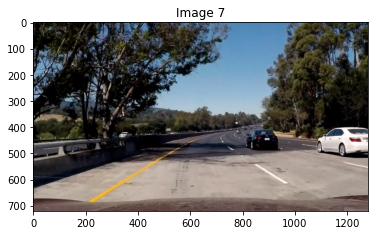

In [24]:
# Reading an image
images_paths = glob.glob("media/test_images/*.jpg")
images = [plt.imread(image) for image in images_paths]

# getting img dimensions and printing it
image_idx = 6

show_image(images[image_idx], "Image " + str(image_idx + 1))

## Read a Video

In [5]:
VideoFlag = False

if (VideoFlag):
    video_paths = glob.glob("media/*.mp4")
    videos = [cv2.VideoCapture(video) for video in video_paths]

    video_idx = 2

    frameCount = int(videos[video_idx].get(cv2.CAP_PROP_FRAME_COUNT))
    frameWidth = int(videos[video_idx].get(cv2.CAP_PROP_FRAME_WIDTH))
    frameHeight = int(videos[video_idx].get(cv2.CAP_PROP_FRAME_HEIGHT))

    frames = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))


    plt.rcParams['figure.max_open_warning'] = frameCount

    fc = 0
    ret = True


    while (fc < frameCount  and ret):
        ret, frames[fc] = videos[video_idx].read()
        fc += 1

    videos[video_idx].release()

    #columns = 4
    limit = 10

    #px = 1/plt.rcParams['figure.dpi']  # pixel in inches
    #plt.subplots(figsize=(600*px, 200*px))
    # for i, frame in enumerate(frames[:limit]):
    #     plt.subplot(len(frames[:limit])// columns + 1, columns, i + 1)
    #     show_image(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB), "Frame " + str(i+1))

    for i, frame in enumerate(frames[:limit]):
        plt.figure()
        show_image(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), "Frame "+ str(i+1))

    #show_image(cv2.cvtColor(frames[1], cv2.COLOR_BGR2RGB), "Frame 2")


## Pipeline Start

In [6]:
### Apply gaussian blue to eliminate noise
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [7]:
def canny(image):    
    # canny to find edges
    #derivative small deriv small change big deriv is an edge
    canny_img = cv2.Canny(image, 50, 150)
    return canny_img

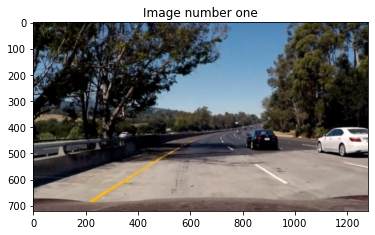

In [8]:
# so that changes are done to the copy
lane_img=np.copy(images[image_idx])

blur_img = gaussian_blur(lane_img, 5)
show_image(blur_img, "Image number one")

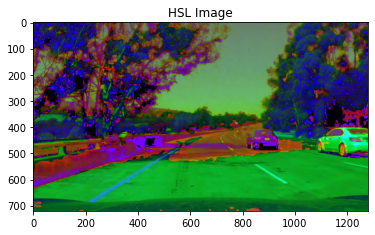

In [9]:
#making the image hls to reduce processing time

hls_img = cv2.cvtColor(blur_img, cv2.COLOR_RGB2HLS)
h_channel = hls_img[:, :, 0]
l_channel = hls_img[:, :, 1]
s_channel = hls_img[:, :, 2]

show_image(hls_img, "HSL Image")

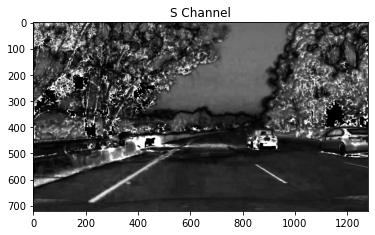

In [10]:
show_image(s_channel, "S Channel")

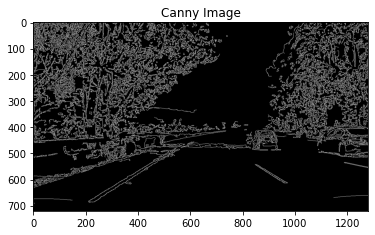

In [11]:
canny_img = canny(s_channel)
show_image(canny_img, "Canny Image")

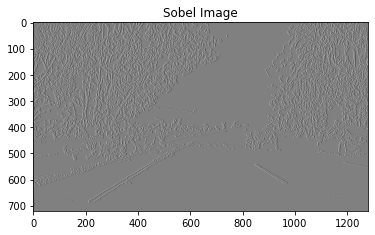

In [12]:
sobelx = cv2.Sobel(canny_img, cv2.CV_64F, 1, 0)
show_image(sobelx, "Sobel Image")

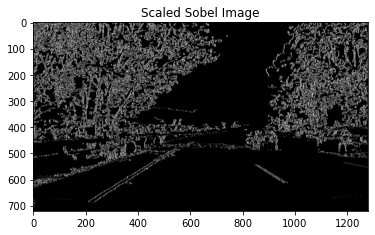

In [13]:
abs_sobel_x = np.absolute(sobelx)
scaled_sobel = (255 * ((abs_sobel_x) / np.max(abs_sobel_x))).astype(np.uint8)
#print((scaled_sobel.dtype))
show_image(scaled_sobel, "Scaled Sobel Image")

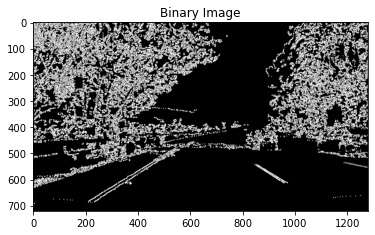

In [14]:
sx_thresh = [20, 200]

sx_binary = np.zeros_like(scaled_sobel)
sx_binary[(scaled_sobel > sx_thresh[0]) & (scaled_sobel < sx_thresh[1])] = 1
show_image(sx_binary, "Binary Image")

In [15]:
#detect lanes using hough

def lane(image):
    height = image.shape[0]
    polygons= np.array([
        [(200,height), (1100,height),(630,410)]
    ])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask,polygons,255)
    #bitwise to show only whats in the mask
    masked_img= cv2.bitwise_and(image, mask)
    
    
    return masked_img

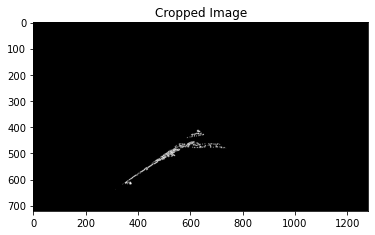

In [16]:
# bitwise and operation mask and canny
cropped_img = lane(sx_binary)
show_image(cropped_img, "Cropped Image")

In [17]:
def display_lines(img,lines):
    line_image= np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1,y1), (x2,y2), (255, 0,0), 10)
            
    return line_image

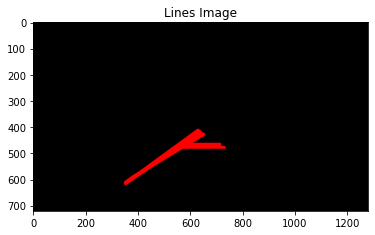

In [18]:
#hough for straight lines
#sufficiently small bins

lines= cv2.HoughLinesP(cropped_img,2, np.pi/180, 120, np.array([]), minLineLength=1, maxLineGap=700)
line_img= display_lines(lane_img, lines)
show_image(line_img, "Lines Image")

In [19]:
# if lines is not None:
#     for line in lines:
#         print(line)

In [20]:
# May Perspective Wrapping
# Need to fix detect lane
# Draw the polygon
# Connecting the lines
# Merging the video frames